# Groundwater flow model: Setup

In [1]:
import sys
sys.path.append('./gwflow')

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import uniform, multivariate_normal
from scipy.stats.qmc import LatinHypercube, scale

import gwflow as gwf
import tinyDA as tda

Ray module not found. Multiprocessing features are not available


/home/mikkel/venv/tinyda/lib/python3.10/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
np.random.seed(123)

In [4]:
gw_parameters = {'extent': (1,1),
                 'resolution': (30, 30),
                 'sources_and_sinks': '0.1',
                 'pumping_rates': [-0.1, -0.05],
                 'pumping_locations': [(0.8, 0.5), (0.3, 0.7)]
                }

n_data = 20
lhs = LatinHypercube(d=2, seed=123)
datapoints = scale(lhs.random(n_data), (0, 0), (gw_parameters['extent'][0], gw_parameters['extent'][1]))

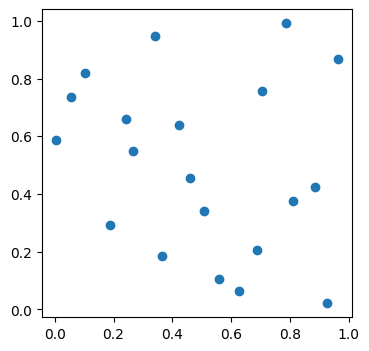

In [5]:
plt.figure(figsize=(4,4))
plt.scatter(datapoints[:,0], datapoints[:,1])
plt.show()

In [6]:
conductivity_parameters = {'conductivity_kernel': gwf.Matern32,
                           'conductivity_lambda': 0.1,
                           'conductivity_mkl': 128,
                           'conductivity_mean': -2,
                           'conductivity_stdev': 1}

parameters = {**gw_parameters, **conductivity_parameters, 'datapoints': datapoints}

In [7]:
my_model = gwf.GwModel(parameters)

### Set up the statistical model

In [8]:
mu_prior = np.zeros(conductivity_parameters['conductivity_mkl'])
sigma_prior = np.eye(conductivity_parameters['conductivity_mkl'])

my_prior = multivariate_normal(mu_prior, sigma_prior)

In [9]:
true_parameters = my_prior.rvs()
#true_parameters = np.loadtxt('true_parameters.csv')
data_pure = my_model(true_parameters)

Object cannot be plotted directly, projecting to piecewise linears.


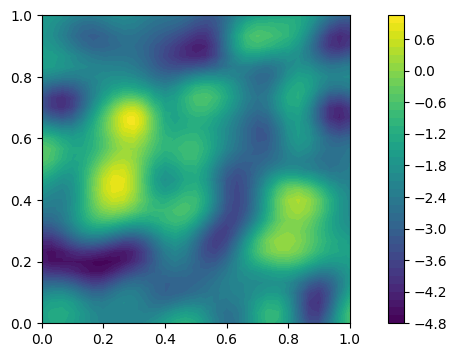

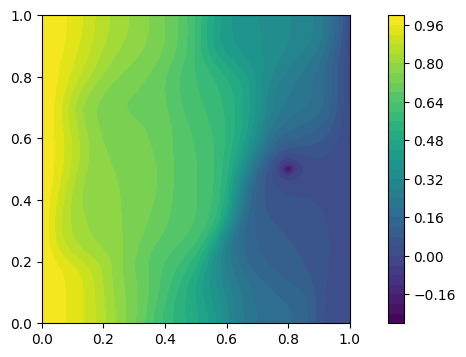

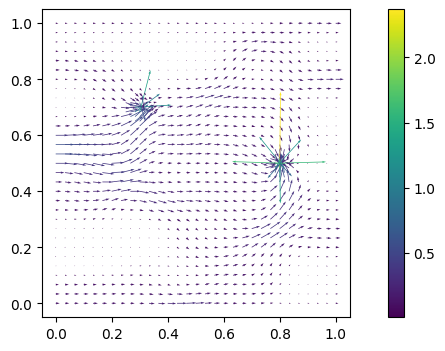

In [10]:
my_model.plot_conductivity()
my_model.plot_head()
my_model.plot_flux()

In [11]:
# set the likelihood
sigma_head = 2e-2
sigma_flux = 1e-2

cov_likelihood = np.diag(np.hstack((np.array([sigma_head**2] * n_data), np.array([sigma_flux**2] * n_data))))
data = data_pure + multivariate_normal(np.zeros(data_pure.shape[0]), cov_likelihood).rvs()

### Set up the coarse model

In [12]:
my_model_coarse = gwf.ReducedModel(my_model, (15, 15))
_ = my_model_coarse(true_parameters)

Object cannot be plotted directly, projecting to piecewise linears.


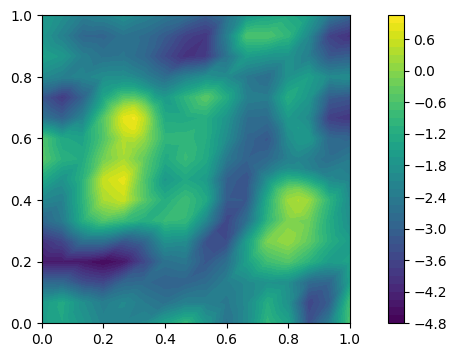

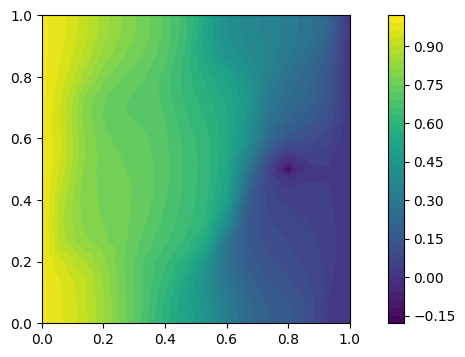

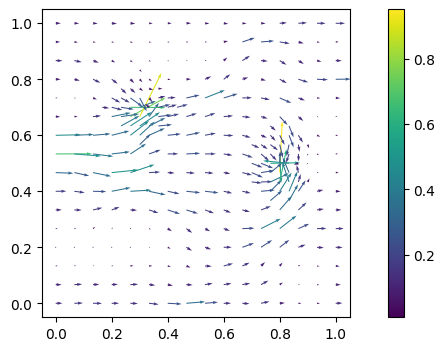

In [13]:
my_model_coarse.plot_conductivity()
my_model_coarse.plot_head()
my_model_coarse.plot_flux()

In [14]:
df = pd.DataFrame({'x': datapoints[:,0], 'y': datapoints[:,1], 'h': data[:n_data], 'q': data[n_data:]})
df.to_csv('data.csv', index=False)
np.savetxt('true_parameters.csv', true_parameters)

In [15]:
my_model.pickle('model.p')
my_model_coarse.pickle('model_coarse.p')